In [1]:
#!pip install sqlalchemy 
#!pip3 install psycopg2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

In [2]:
db_config = {
    'user': 'postgres', # имя пользователя
    'pwd': 'q1w2e34r', # пароль
    'host': 'localhost',
    'port': 5432, # порт подключения
    'db': 'new_base' # название базы данных
}  

In [7]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

In [8]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [9]:
engine = create_engine(connection_string) 

In [10]:
query = '''
WITH profile AS
  (SELECT user_id,
          dt,
          COUNT(*) OVER (PARTITION BY dt) AS cohort_users_cnt
   FROM online_store.profiles
   WHERE channel = 'Organic'),
sessions AS 
(SELECT user_id,
        session_start::date AS session_date
FROM online_store.sessions
GROUP BY 1,
         2)
SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
''' 

In [11]:
retention_rate_df = pd.read_sql_query(query, con = engine) 

In [12]:
retention_rate_df.head()

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2020-06-15,2020-06-21,688,4139,16.62
1,2020-06-17,2020-06-25,110,5600,1.96
2,2020-06-17,2020-06-24,122,5600,2.18
3,2020-06-22,2020-06-25,1059,4450,23.80
4,2020-06-16,2020-06-20,222,4438,5.00


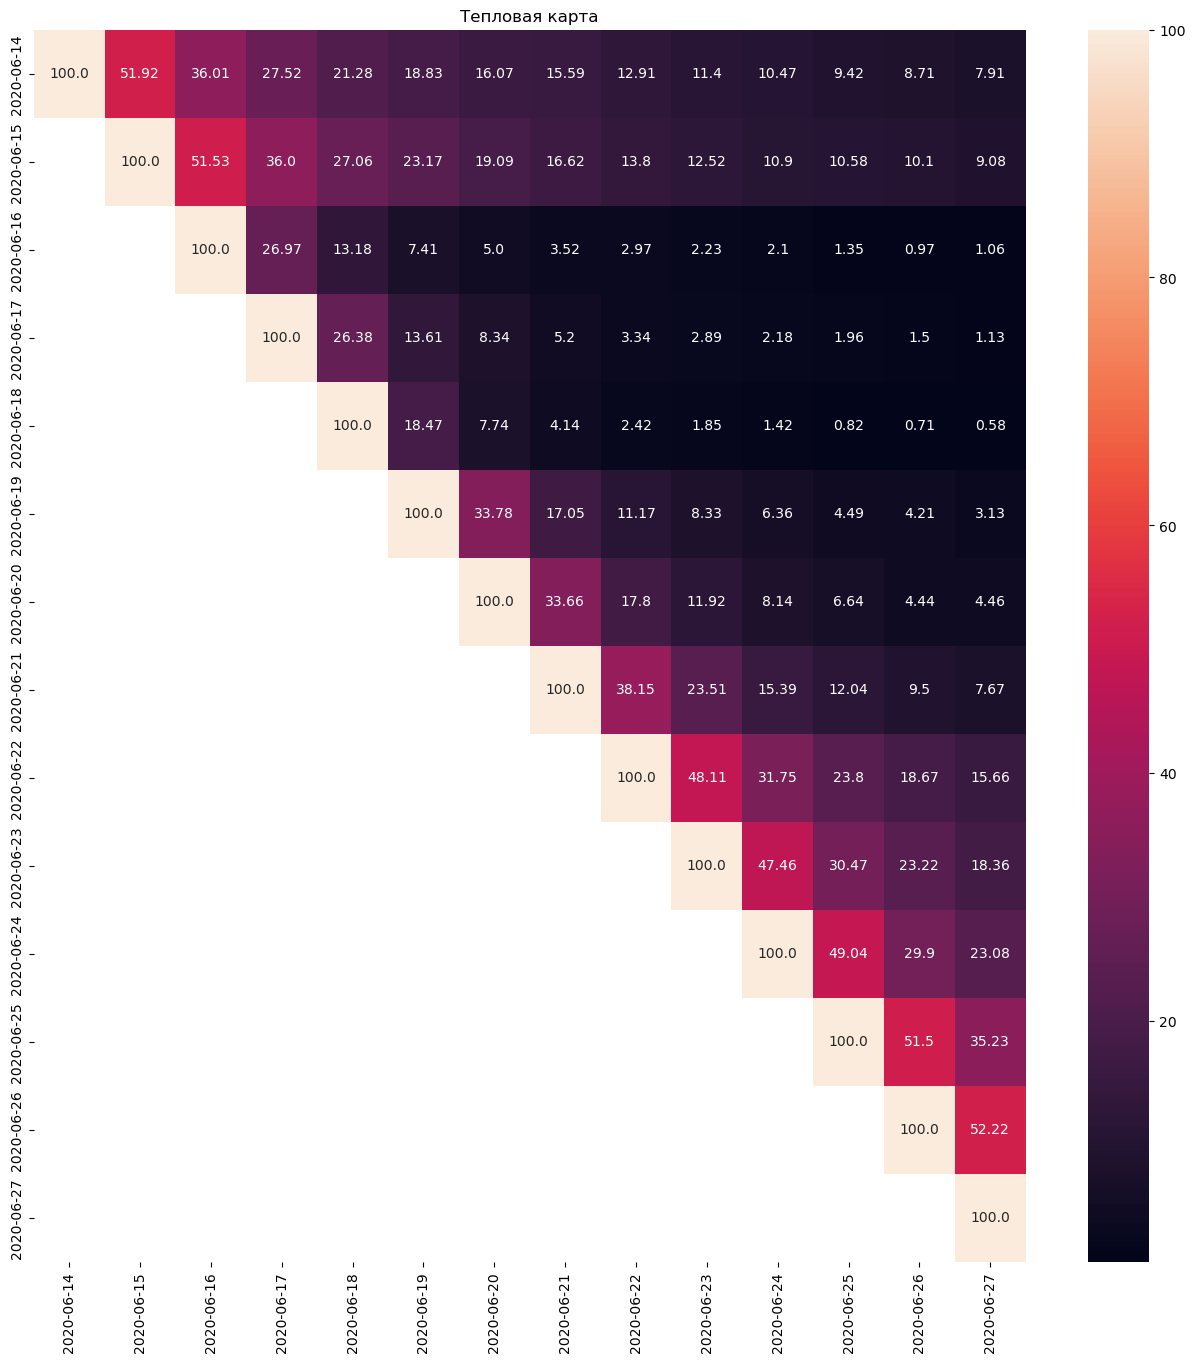

In [13]:
retention = retention_rate_df.pivot(index='cohort_dt', columns='session_date', values='retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

In [32]:
query_cr = '''
WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS start_mn
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
sessions AS
  (SELECT start_mn,
          DATE_TRUNC('month', event_time)::date AS event_mn,
          COUNT(DISTINCT p.user_id) AS users_cnt
   FROM profile p
   JOIN tools_shop.events e ON p.user_id = e.user_id
   GROUP BY 1,
            2)
SELECT start_mn,
       event_mn,
       users_cnt,
       LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn) AS previous_month_users_cnt,
       ROUND((1 - (users_cnt::numeric / LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn))) * 100, 2) AS churn_rate
FROM sessions
WHERE start_mn BETWEEN '2018-01-01' AND '2018-06-01'
  AND event_mn BETWEEN '2018-01-01' AND '2018-12-01'; 
''' 

In [33]:
churn_rate_df = pd.read_sql_query(query_cr, con = engine) 

In [34]:
churn_rate_df.head()

,start_mn,event_mn,users_cnt,previous_month_users_cnt,churn_rate
0,2018-01-01,2018-01-01,257,NaN,NaN
1,2018-01-01,2018-02-01,67,257.0,73.93
2,2018-01-01,2018-03-01,41,67.0,38.81
3,2018-01-01,2018-04-01,44,41.0,-7.32
4,2018-01-01,2018-05-01,42,44.0,4.55


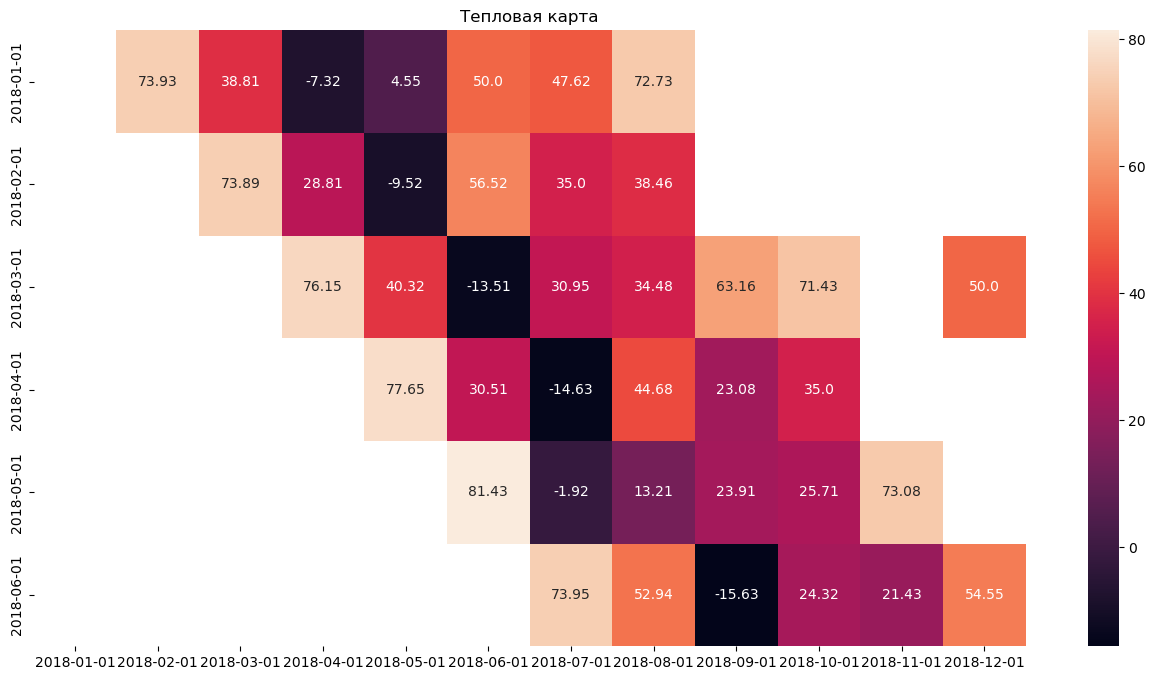

In [28]:
churn = churn_rate_df.pivot(index='start_mn', columns='event_mn', values='churn_rate')
churn.index = [str(x)[0:10] for x in churn.index]
churn.columns = [str(x)[0:10] for x in churn.columns]

# строим хитмэп
plt.figure(figsize=(16, 8)) # задаём размер графика
sns.heatmap(churn, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 